# Find my Star

### Imports

In [ ]:
import time
import math
import cv2
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.spatial import KDTree
from  scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import transforms
import matplotlib.image as mpimg

## Testing

In [717]:
def viz_levels(image):
    cut_levels = pd.Series(image.flatten()).value_counts(bins=50).reset_index().set_axis(['value', 'count'], axis=1)
    cut_levels['value'] = [int(i.mid) for i in cut_levels['value']]
    cut_levels = cut_levels[cut_levels['value'] > 5]
    plt.bar(cut_levels['value'], cut_levels['count'], width=4, color='royalblue')
    return

In [718]:
def light_percent(image):
    all_coords = np.column_stack(np.where(image >= 0))
    grey_coords = np.column_stack(np.where(image > 0))
    print(f"the image is {np.round(grey_coords.size/all_coords.size*100, 2)}% light")

### Image Importing and exploring

In [719]:
# import reference image
ref_img = "data/reference/star_chart_ireland_2024-10-11_01-00.jpg"
ref_grey = cv2.imread(ref_img, flags=cv2.IMREAD_GRAYSCALE)
ref_grey.shape


(1111, 1111)

In [720]:
ref_grey = cv2.resize(ref_grey, dsize=(1000,1000))
ref_grey.shape


(1000, 1000)

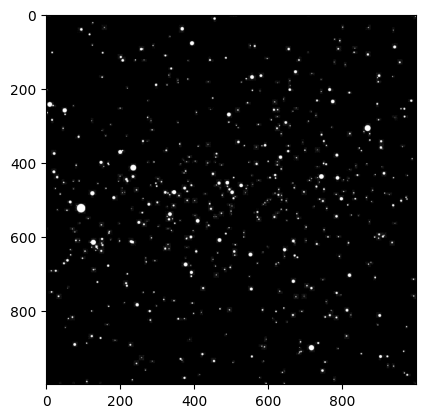

the image is 8.6% light


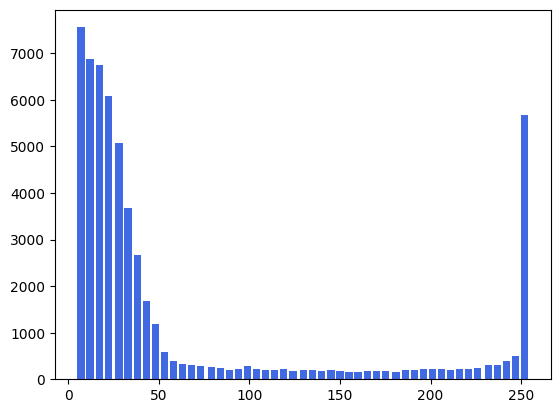

In [721]:
# get reference coords
plt.imshow(ref_grey, cmap="grey")
plt.show()
light_percent(ref_grey)
viz_levels(ref_grey)


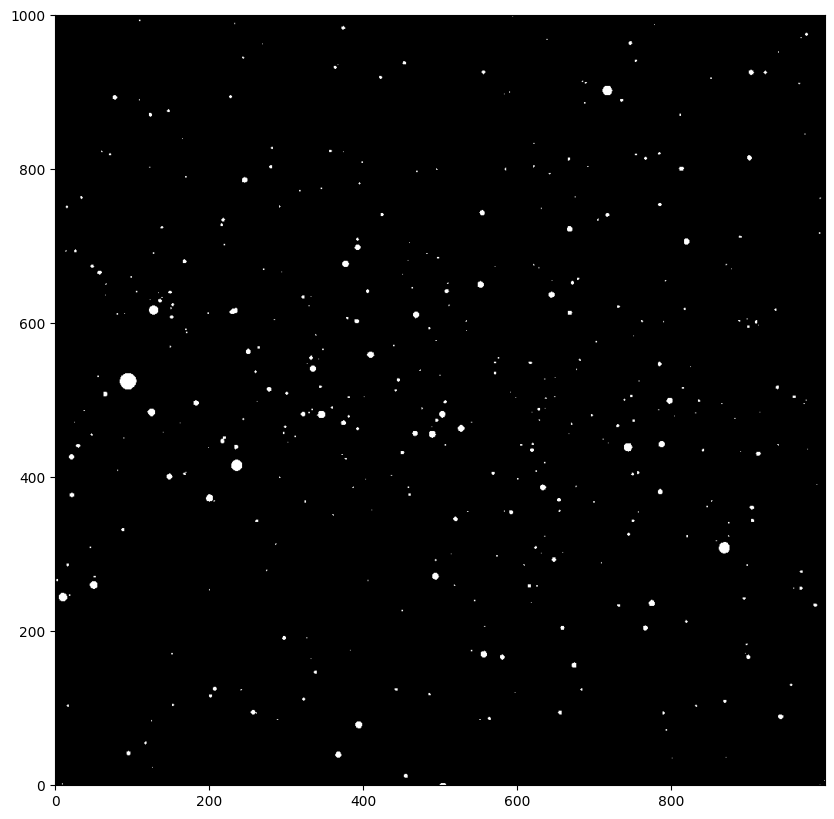

the image is 0.57% light


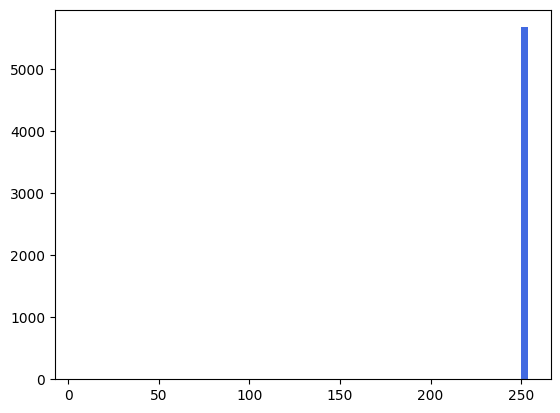

In [922]:
# remove all data below cutoff and visualize
hard_cut_ref = ref_grey.copy()
hard_cut_ref[hard_cut_ref<250] = 0

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(hard_cut_ref, cmap="grey")
ax.set_ylim([0, 1000])
plt.show()
light_percent(hard_cut_ref)
viz_levels(hard_cut_ref)


In [723]:
# import test image no. 1
test_img = "data/testing/astro1.jpeg"
test_grey = cv2.imread(test_img, flags=cv2.IMREAD_GRAYSCALE)
test_grey = test_grey[:min(test_grey.shape), :min(test_grey.shape)]
test_grey = cv2.resize(test_grey, dsize=(1000,1000))
test_grey.shape

(1000, 1000)

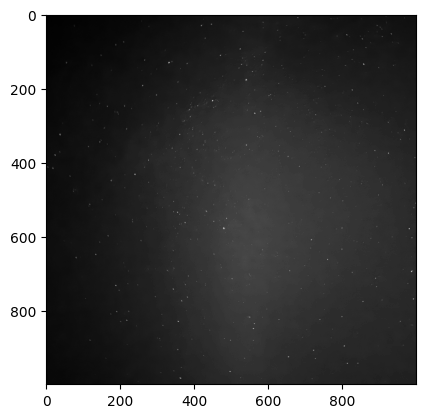

the image is 100.0% light


In [724]:
plt.imshow(test_grey, cmap="grey")
plt.show()
light_percent(test_grey)

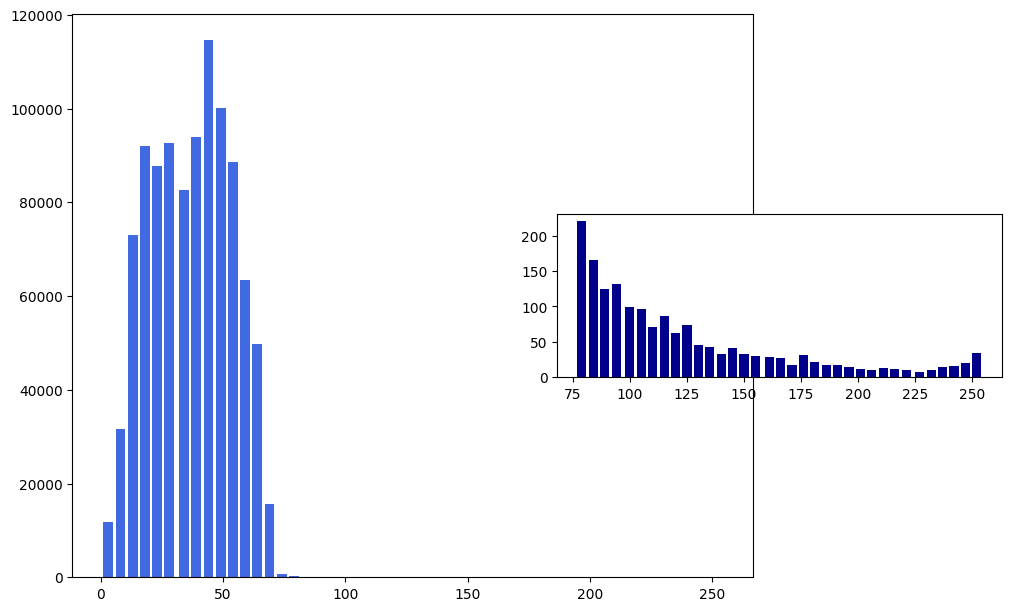

In [725]:
# visulize noise cutoff
test_levels = pd.Series(test_grey.flatten()).value_counts(bins=50).reset_index().set_axis(['value', 'count'], axis=1)
test_levels['value'] = [int(i.mid) for i in test_levels['value']]
high_test_levels = test_levels[test_levels['value'] >= 77]

fig = plt.figure(constrained_layout=True, figsize=(10,6))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[:, 0:3])
ax2 = fig.add_subplot(gs[1, 2:4])

ax1.bar(test_levels['value'], test_levels['count'], width=4, color='royalblue')
ax2.bar(high_test_levels['value'], high_test_levels['count'], width=4, color='darkblue')
plt.show()


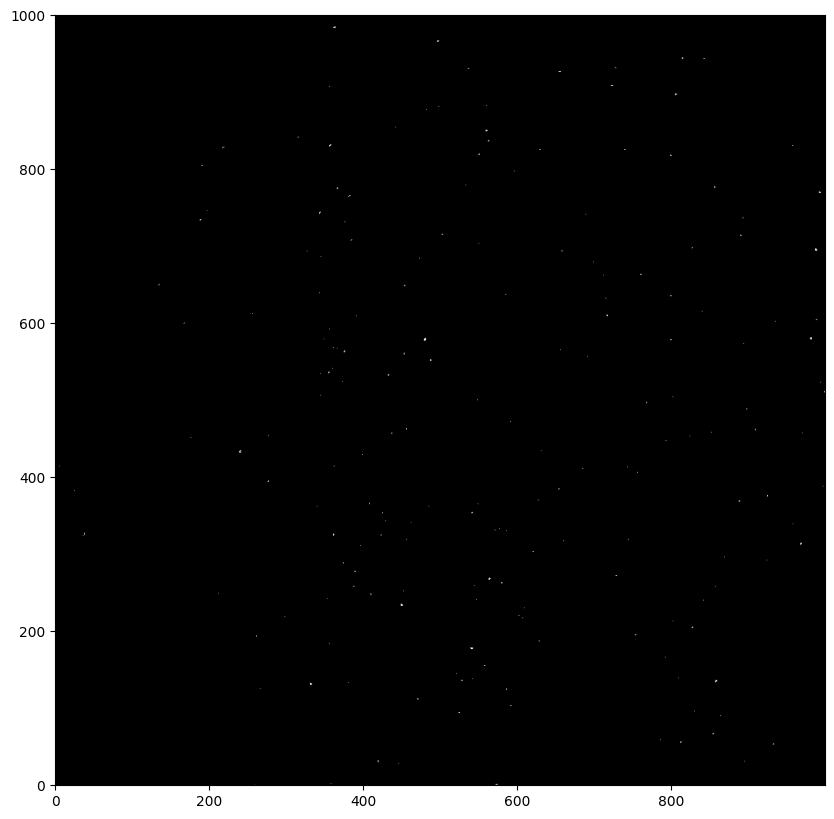

the image is 0.04% light


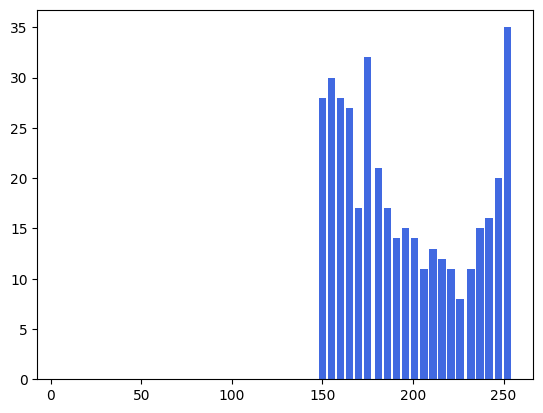

In [726]:
# remove all data below cutoff and visualize
hard_cut_test = test_grey.copy()
hard_cut_test[hard_cut_test<150] = 0
plt.subplots(figsize=(10,10))
plt.imshow(hard_cut_test, cmap="grey")
ax = plt.gca()
ax.set_ylim([0, 1000])
plt.show()
light_percent(hard_cut_test)
viz_levels(hard_cut_test)

### Image Transformation

In [727]:
# transform to binary maps
_, ref_bi = cv2.threshold(hard_cut_ref, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, test_bi = cv2.threshold(hard_cut_test, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ref_bi.shape, test_bi.shape

((1000, 1000), (1000, 1000))

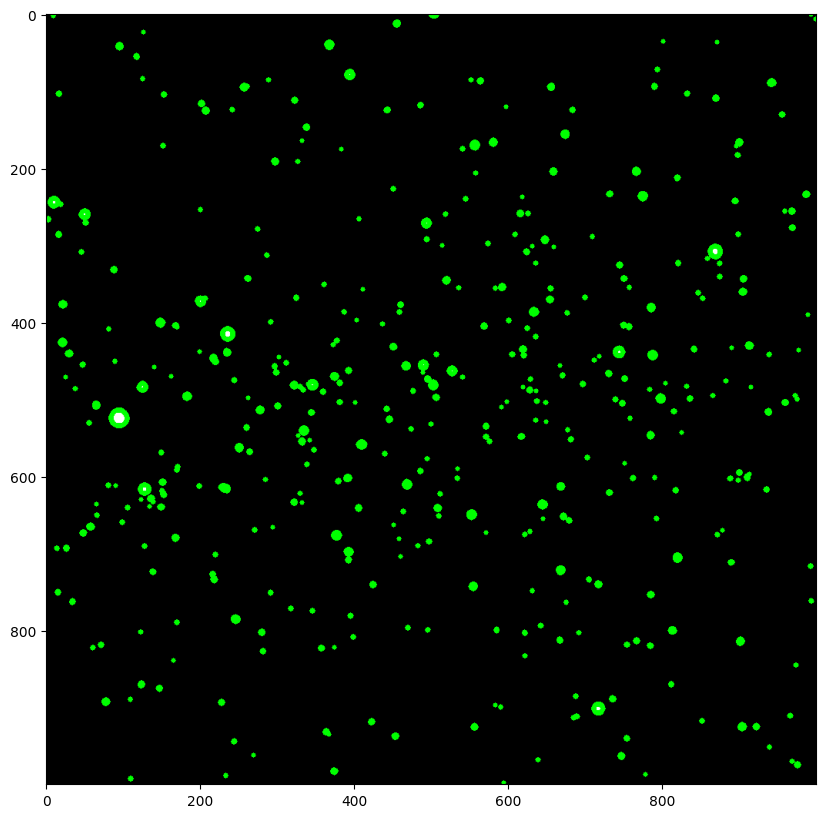

reference: [[594], [998]], (len=406)


In [728]:
# find contours
ref_color = cv2.cvtColor(hard_cut_ref, cv2.COLOR_GRAY2RGB)
ref_cont, _ = cv2.findContours(ref_bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(ref_color, ref_cont, -1, (0,255,0), 5)
plt.subplots(figsize=(10,10))
plt.imshow(ref_color)
plt.show()

ref_contours = [[[pt[0][0] for pt in cont],[pt[0][1] for pt in cont]] for cont in ref_cont]
print(f'reference: {ref_contours[0]}, (len={len(ref_contours)})')


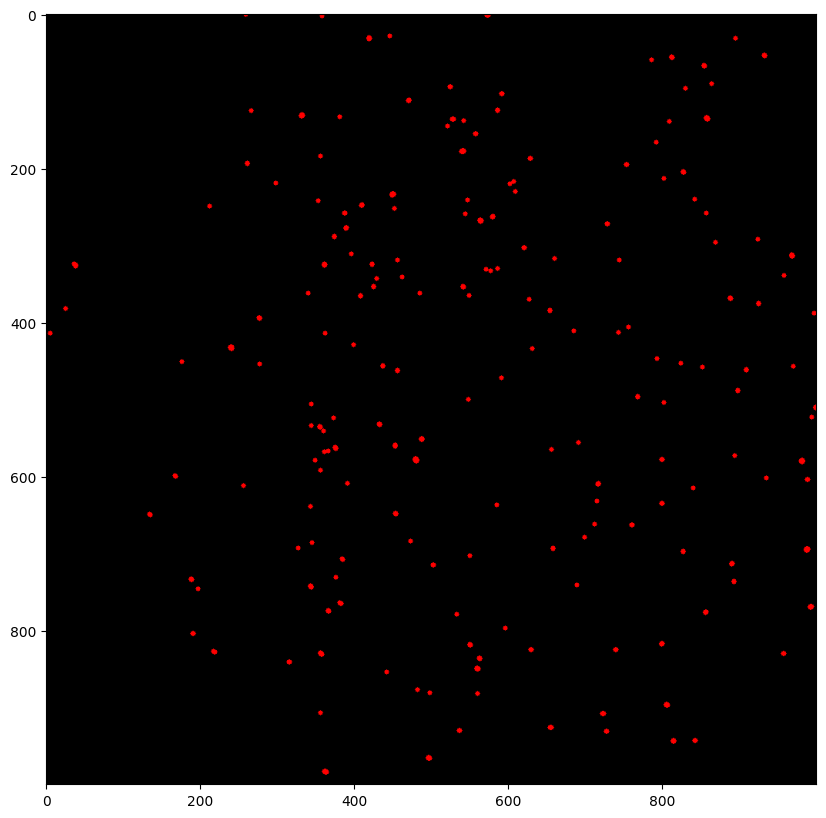

test: [[361, 362, 364, 363], [983, 984, 984, 983]], (len=189)


In [729]:
test_color = cv2.cvtColor(hard_cut_test, cv2.COLOR_GRAY2RGB)
test_cont, _ = cv2.findContours(test_bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(test_color, test_cont, -1, (255,0,0), 5)
plt.subplots(figsize=(10,10))
plt.imshow(test_color)
plt.show()

test_contours = [[[pt[0][0] for pt in cont],[pt[0][1] for pt in cont]] for cont in test_cont]
print(f'test: {test_contours[0]}, (len={len(test_contours)})')


In [730]:
# i = 0
# for cont in ref_contours:
#     xs = cont[0]
#     ys = cont[1]
#     plt.plot(xs, ys, 'sb', mfc='xkcd:sky blue', markersize=300/len(cont[0]))

#     xroll = np.roll(xs,1)
#     yroll = np.roll(ys,1)
#     poly_area = np.abs(np.dot(xs, yroll) - np.dot(ys, xroll))/2
#     if poly_area == 0:
#         avg_x = np.mean(xs)
#         avg_y = np.mean(ys)
#         print(avg_x, avg_y)
#         plt.plot([avg_x], [avg_y], 'or', label='average')
#     else:
#         Cx = np.sum((xs + xroll) * (xs * yroll - xroll * ys))/(6*poly_area)
#         Cy = np.sum((ys + yroll) * (xs * yroll - xroll * ys))/(6*poly_area)
#         print(Cx, Cy)
#         plt.plot([Cx], [Cy], 'og', label='centroid')

#     xs = cont[0] + [cont[0][0]]
#     ys = cont[1] + [cont[1][0]]
#     plt.plot(xs, ys, '-p')

#     plt.legend()
#     plt.margins(0.5, 0.5)
#     plt.show()
#     i+= 1
#     if i == 10:
#         break

In [731]:
def get_centroids(contours):
    cxs = []
    cys = []

    for cont in contours:
        xs = cont[0]
        ys = cont[1]

        xroll = np.roll(xs,1)
        yroll = np.roll(ys,1)
        poly_area = np.abs(np.dot(xs, yroll) - np.dot(ys, xroll))/2
        if poly_area == 0:
            cx = np.round(np.mean(xs), 2)
            cy = np.round(np.mean(ys), 2)
        else:
            cx = np.round(np.sum((xs + xroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)
            cy = np.round(np.sum((ys + yroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)

        cxs.append(cx)
        cys.append(cy)

    return [cxs, cys]

reference centroids: 406


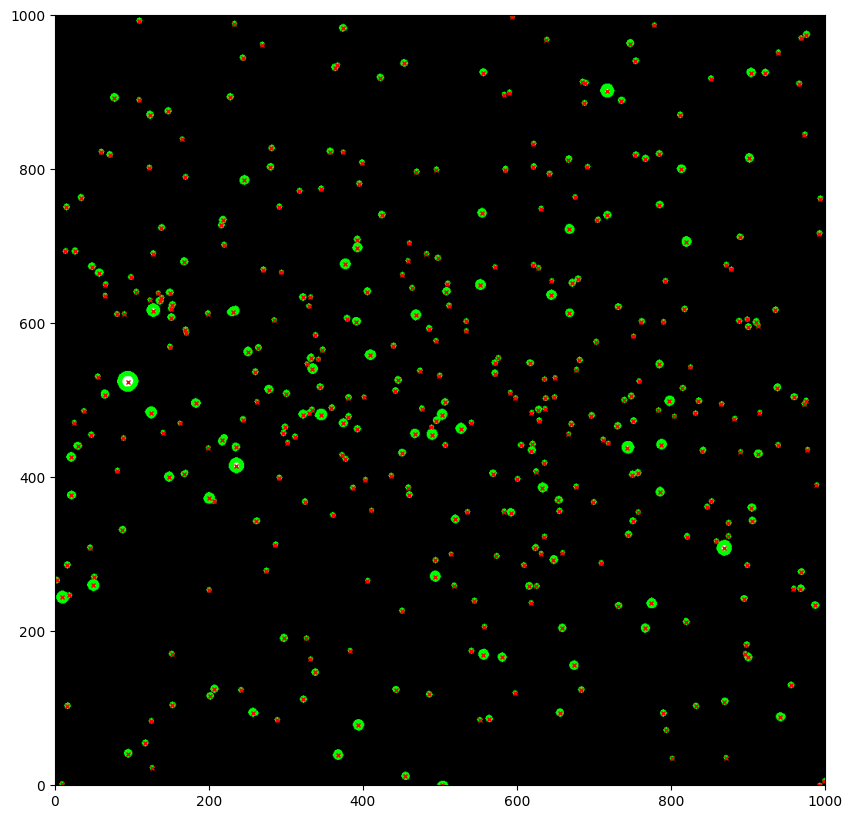

In [732]:
ref_cent_x, ref_cent_y = get_centroids(ref_contours)
print(f'reference centroids: {len(ref_cent_x)}')
plt.subplots(figsize=(10,10))
plt.imshow(ref_color)
plt.plot(ref_cent_x, ref_cent_y, 'xr', markersize=3)
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
plt.show()

reference centroids: 189


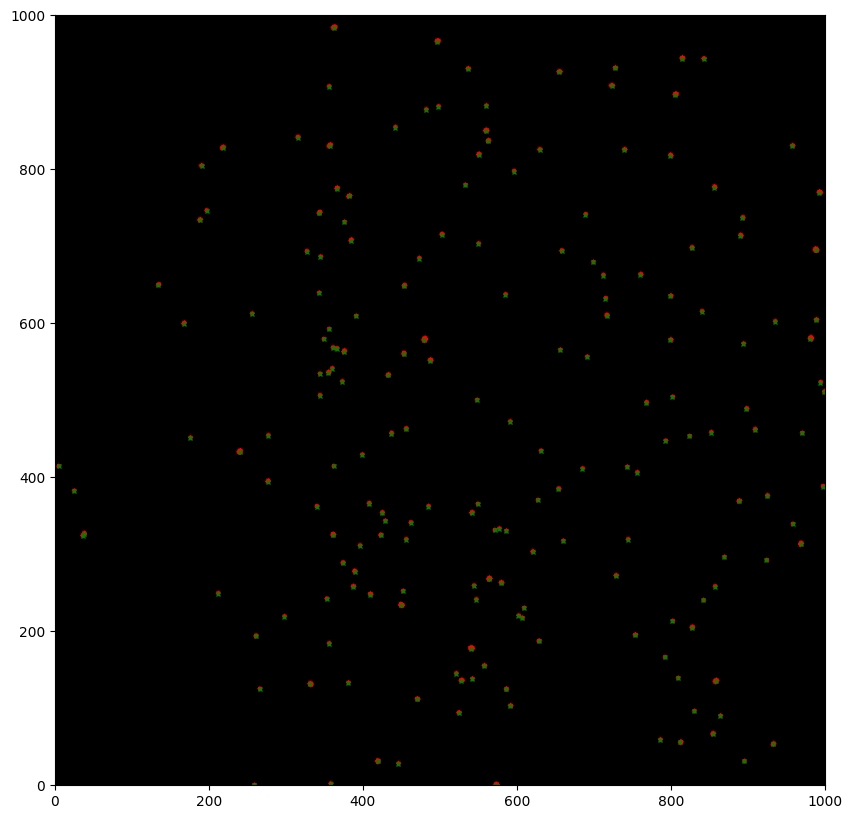

In [733]:
test_cent_x, test_cent_y = get_centroids(test_contours)
print(f'reference centroids: {len(test_cent_x)}')
plt.subplots(figsize=(10,10))
plt.imshow(test_color)
plt.plot(test_cent_x, test_cent_y, 'xg', markersize=3)
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
plt.show()

In [734]:
# # get triangles

# def update_counts(star_counts, fin_stars, n_pts):
#     for n_pt in n_pts:
#         if star_counts[n_pt] == 0:
#             continue
#         else:
#             star_counts[n_pt] -= 1
#         if star_counts[n_pt] == 0:
#             fin_stars.add(n_pt)


# centroids = list(zip(ref_cent_x, ref_cent_y))
# star_tree = KDTree(centroids)

# star_counts = [6 for r in range(len(centroids))]
# fin_stars = set([])

# _, first_idxs = star_tree.query((500,500), k=1)
# triangles = []

# triangle = [centroids[first_idxs]]
# tri_ids = [first_idxs]

# b = 0
# while b < 100:

#     k = 6
#     while len(triangle) < 3:
#         dists, sidxs = star_tree.query([triangle[0]], k=k)
#         try:
#             n_pts = [x for x in sidxs[0][1:] if x not in fin_stars and star_counts[x] > 0]
#             points = [centroids[n_pt] for n_pt in n_pts]
#             if len(n_pts) > 1:
#                 idxs = [np.where(sidxs == n_pt) for n_pt in n_pts]
#                 dists = [dists[i] for i in idxs]
#                 s_dists = [sum(dists[0]), sum(dists[1])]
#                 n_pt = n_pts[s_dists.index(min(s_dists))]
#             else:
#                 n_pt = n_pts[0]
#             triangle.append(centroids[n_pt])
#             tri_ids.append(n_pt)

#         except IndexError:
#             print('Index error:')
#             print('sidxs', sidxs)
#             print('star_counts', star_counts)
#             break

#         k += 1

#     triangles.append(triangle)
#     update_counts(star_counts, fin_stars, tri_ids)

#     triangle = [triangle[1]]
#     tri_ids = [tri_ids[1]]

#     b += 1


In [735]:
# trixs, triys = zip(*triangles[0])
# fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(ref_cent_x, ref_cent_y, 'or', markersize=1, alpha=0.5)
# colors = ['red', 'green', 'blue', 'magenta', 'yellow', 'cyan']
# c = 0
# for tri in triangles:
#     ax.add_patch(Polygon(tri, alpha=0.5, edgecolor='black', facecolor=colors[c], linewidth=2))
#     if c < len(colors) - 1:
#         c += 1
#     else:
#         c = 0
# ax = plt.gca()
# ax.set_xlim([0, 1000])
# ax.set_ylim([0, 1000])
# plt.show()

In [736]:
# from the center point, find the 3 closest points that,
# when connected, form a triangle around the center point

def area(X, Y, n):
    area = 0.0
    j = n - 1
    for i in range(0,n):
        area += (X[j] + X[i]) * (Y[j] - Y[i])
        j = i

    return abs(area / 2.0)

def get_triangles(center, ABC):
    PAB = [center, ABC[0], ABC[1]]
    PBC = [center, ABC[1], ABC[2]]
    PAC = [center, ABC[0], ABC[2]]

    return ABC, [PAB, PBC, PAC]

def get_coords(triangle):
    X = [x[0] for x in triangle]
    Y = [x[1] for x in triangle]
    return X, Y

def check_areas(center_star, outer_stars):
    if len(outer_stars) > 3:
        poss_triangles = list(combinations(outer_stars, 3))
    else:
        poss_triangles = [outer_stars]

    for triangle in poss_triangles:
        outer_tri, inner_tris = get_triangles(center_star, triangle)
        outer_area = area(*get_coords(outer_tri), 3)

        inner_area = 0
        for tri in inner_tris:
            inner_area += area(*get_coords(tri), 3)

        if abs(outer_area - inner_area) < 1e-9:
            return triangle


In [737]:
# centroids = list(zip(ref_cent_x, ref_cent_y))
# star_tree = KDTree(centroids)

# ks = np.arange(10, 100, 10)
# none_amts = []
# times = []
# for k in ks:
#     triangles = []
#     start = time.time()
#     for star in centroids:
#         _, center_idx = star_tree.query(star, k=1)
#         center_star = centroids[center_idx]

#         _, central_idxs = star_tree.query(star, k=k)
#         outer_stars = [centroids[i] for i in central_idxs[1:]]

#         emcomp_tri = check_areas(center_star, outer_stars)
#         triangles.append(emcomp_tri)

#     end = time.time()
#     times.append(end - start)
#     none_amts.append(triangles.count(None))


In [738]:
# fig, ax1 = plt.subplots()

# ax1.set_xlabel('k')
# ax1.set_ylabel('None Values')
# ax1.plot(ks, none_amts, color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Time (s)')
# ax2.plot(ks, times, color='red')
# ax2.tick_params(axis='y', labelcolor='red')

# fig.tight_layout()
# plt.show()

In [739]:
centroids = list(zip(ref_cent_x, ref_cent_y))
star_tree = KDTree(centroids, )

triangles = []
central_stars = []
loners = []
for star in centroids:
    _, center_idx = star_tree.query(star, k=1)
    center_star = centroids[center_idx]

    _, central_idxs = star_tree.query(star, k=70)
    outer_stars = [centroids[i] for i in central_idxs[1:]]

    emcomp_tri = check_areas(center_star, outer_stars)
    if emcomp_tri:
        triangles.append(emcomp_tri)
        central_stars.append(star)
    else:
        loners.append(star)


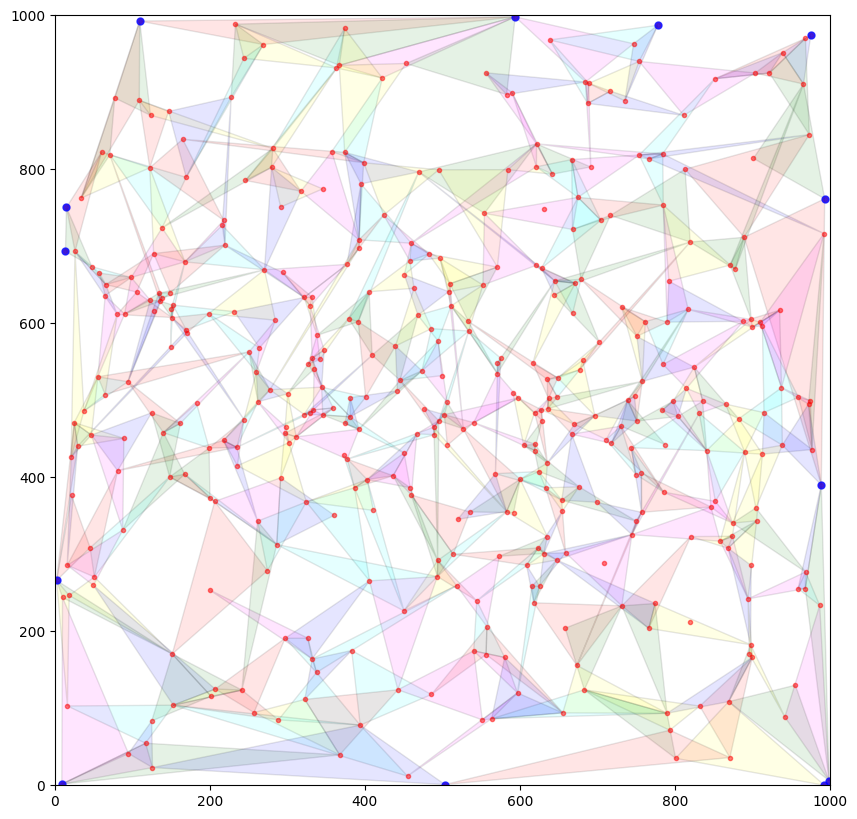

In [740]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ref_cent_x, ref_cent_y, 'or', markersize=3, alpha=0.5)
ax.plot([x[0] for x in loners], [x[1] for x in loners], 'ob', markersize=5, alpha=0.75)
colors = ['red', 'green', 'blue', 'magenta', 'yellow', 'cyan']
c = 0
for tri in triangles:
    ax.add_patch(Polygon(tri, alpha=0.1, edgecolor='black', facecolor=colors[c], linewidth=1))
    if c < len(colors) - 1:
        c += 1
    else:
        c = 0
ax = plt.gca()
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
plt.show()

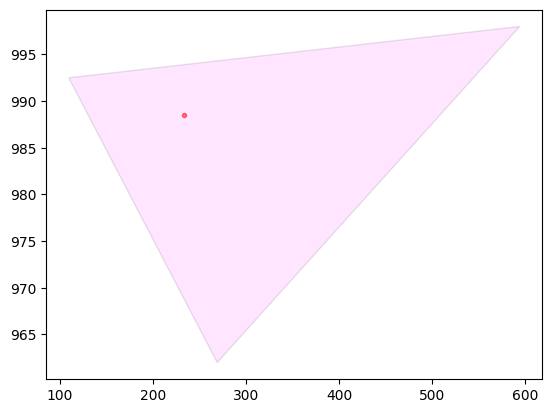

In [741]:
fig, ax = plt.subplots()
ax.plot(central_stars[0][0], central_stars[0][1], 'or', markersize=3, alpha=0.5)
ax.add_patch(Polygon(triangles[0], alpha=0.1, edgecolor='black', facecolor=colors[c], linewidth=1))
plt.show()

In [742]:
# d = sqrt [(x2 - x1)^2 + (y2 - y1)^2]
# theta = arccos((a^2 + b^2 - c^2) / 2ab)

In [743]:
def get_distance(p1, p2):
	return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def get_angles(triangle, P):

    A, B, C = triangle

    AP = get_distance(A, P)
    BP = get_distance(B, P)
    CP = get_distance(C, P)
    AB = get_distance(A, B)
    BC = get_distance(B, C)
    AC = get_distance(A, C)

    angle1 = math.acos((AP**2 + BP**2 - AB**2) / (2 * AP * BP)) * 180 / math.pi
    angle2 = math.acos((BP**2 + CP**2 - BC**2) / (2 * BP * CP)) * 180 / math.pi
    angle3 = math.acos((CP**2 + AP**2 - AC**2) / (2 * CP * AP)) * 180 / math.pi

    angle_sum = sum([angle1, angle2, angle3])
    if 360 - angle_sum > 1e-9:
        print('error', angle_sum)

    return angle1, angle2, angle3

angles = []
for i in range(len(triangles)):
    angles.append(get_angles(triangles[i], central_stars[i]))


## Matching

In [ ]:
def process_image(image, cutoff):
    grey_img = cv2.imread(image, flags=cv2.IMREAD_GRAYSCALE)
    sq_img = grey_img[:min(grey_img.shape), :min(grey_img.shape)]
    sm_img = cv2.resize(sq_img, dsize=(1000,1000))
    cut_img = sm_img.copy()
    cut_img[cut_img<cutoff] = 0
    _, bi_img = cv2.threshold(cut_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return bi_img


def get_centroids(contours, test=False):
    contours = [[[pt[0][0] for pt in cont],[pt[0][1] for pt in cont]] for cont in contours]

    centroids = []
    for cont in contours:
        xs = cont[0]
        ys = cont[1]

        xroll = np.roll(xs,1)
        yroll = np.roll(ys,1)
        poly_area = abs(np.dot(xs, yroll) - np.dot(ys, xroll))/2

        if poly_area == 0:
            cx = np.round(np.mean(xs), 2)
            cy = np.round(np.mean(ys), 2)
        else:
            cx = np.round(np.sum((xs + xroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)
            cy = np.round(np.sum((ys + yroll) * (xs * yroll - xroll * ys))/(6 * poly_area), 2)

        centroids.append((cx, cy))

    if test:
        # centroids = np.array(centroids)[:, ::-1]
        return centroids

    return centroids


def area(X, Y, n):
    area = 0.0
    j = n - 1
    for i in range(0,n):
        area += (X[j] + X[i]) * (Y[j] - Y[i])
        j = i

    return abs(area / 2.0)


def get_triangles(center, ABC):
    PAB = [center, ABC[0], ABC[1]]
    PBC = [center, ABC[1], ABC[2]]
    PAC = [center, ABC[0], ABC[2]]

    return ABC, [PAB, PBC, PAC]


def get_coords(triangle):
    X = [x[0] for x in triangle]
    Y = [x[1] for x in triangle]

    return X, Y


def check_areas(center_star, outer_stars):
    if len(outer_stars) > 3:
        poss_triangles = list(combinations(outer_stars, 3))
    else:
        poss_triangles = [outer_stars]

    for triangle in poss_triangles:
        outer_tri, inner_tris = get_triangles(center_star, triangle)
        outer_area = area(*get_coords(outer_tri), 3)

        inner_area = 0
        for tri in inner_tris:
            inner_area += area(*get_coords(tri), 3)

        if abs(outer_area - inner_area) < 1e-9:
            return triangle


def get_distance(p1, p2):
	return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def get_triangulators(stars, star_tree):
    triangles = []
    central_stars = []
    for star in stars:
        _, center_idx = star_tree.query(star, k=1)
        center_star = stars[center_idx]

        _, central_idxs = star_tree.query(star, k=70)
        outer_stars = [stars[i] for i in central_idxs[1:]]

        emcomp_tri = check_areas(center_star, outer_stars)
        if emcomp_tri:
            triangles.append(emcomp_tri)
            central_stars.append(star)

    return triangles, central_stars


def get_angles(triangles, central_stars):
    angles = []
    for i in range(len(triangles)):
        A, B, C = triangles[i]
        P = central_stars[i]

        AP = get_distance(A, P)
        BP = get_distance(B, P)
        CP = get_distance(C, P)
        AB = get_distance(A, B)
        BC = get_distance(B, C)
        AC = get_distance(A, C)

        angle1 = math.acos((AP**2 + BP**2 - AB**2) / (2 * AP * BP)) * 180 / math.pi
        angle2 = math.acos((BP**2 + CP**2 - BC**2) / (2 * BP * CP)) * 180 / math.pi
        angle3 = math.acos((CP**2 + AP**2 - AC**2) / (2 * CP * AP)) * 180 / math.pi

        inner = sorted([angle1, angle2, angle3])

        angle4 = math.acos((AB**2 + AP**2 - BP**2) / (2 * AB * AP)) * 180 / math.pi
        try:
            angle5 = math.acos((AB**2 + BP**2 - AP**2) / (2 * AB * BP)) * 180 / math.pi
        except ValueError:
            angle5 = 0
        angle6 = math.acos((BC**2 + BP**2 - CP**2) / (2 * BC * BP)) * 180 / math.pi
        angle7 = math.acos((BC**2 + CP**2 - BP**2) / (2 * BC * CP)) * 180 / math.pi
        angle8 = math.acos((AC**2 + AP**2 - CP**2) / (2 * AC * AP)) * 180 / math.pi
        angle9 = math.acos((AC**2 + CP**2 - AP**2) / (2 * AC * CP)) * 180 / math.pi

        outer = sorted([angle4, angle5, angle6, angle7, angle8, angle9])

        angles.append(inner + outer)

    return angles

In [892]:
def main(img, cutoff, test=False):
    proc_img = process_image(img, cutoff)
    contours, _ = cv2.findContours(proc_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = get_centroids(contours, test)
    star_tree = KDTree(centroids, )
    triangles, central_stars = get_triangulators(centroids, star_tree)
    angles = get_angles(triangles, central_stars)
    return central_stars, triangles, angles

In [893]:
ref_stars, ref_tris, ref_angles = main('data/reference/star_chart_ireland_2024-10-11_01-00.jpg', cutoff=250)
test_stars, test_tris, test_angles = main('data/testing/astro1.jpeg', cutoff=150, test=True)

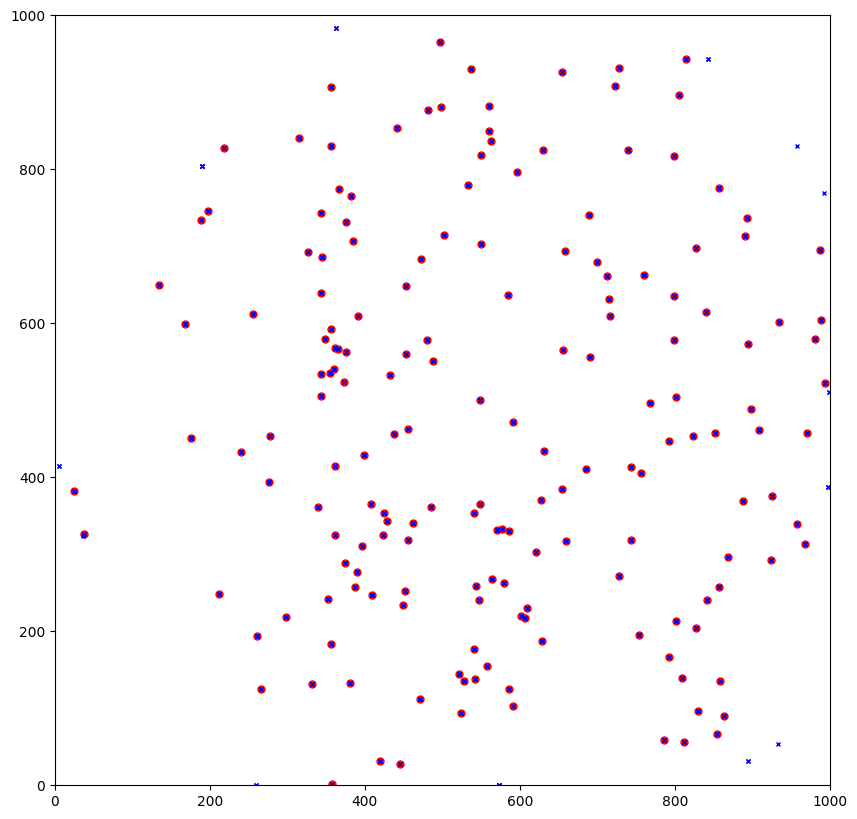

In [894]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.array(test_stars)[:, 0], np.array(test_stars)[:, 1], 'ro', markersize=5)
ax.plot(np.array(test_tris)[:, :, 0], np.array(test_tris)[:, :, 1], 'bx', markersize=3)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
plt.show()


In [895]:
# compare ref and test angles and find closest match

ref_tree = KDTree(ref_angles)

good_matches = []
dists = []
for t, test_set in enumerate(test_angles):
    dist, r = ref_tree.query(test_set, k=1)
    if dist < 20:
        good_matches.append([r, t])
        dists.append(dist)

len(good_matches)

175

2.94244321673517
0.03 5.66157378295452


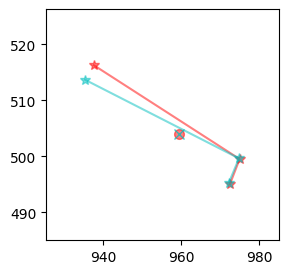

6.503813914636633
0.06 47.03213654321638


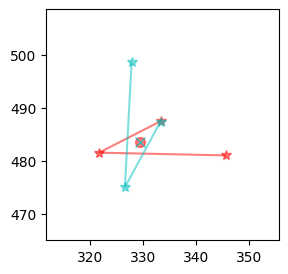

8.201161224713005
0.07 7.421864085789139


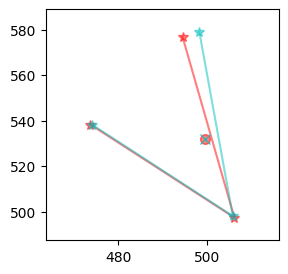

7.705961337819516
0.09 3.6015462057540333


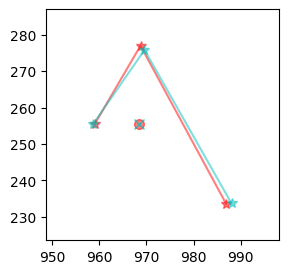

8.10648382333342
0.04 5.528385907891533


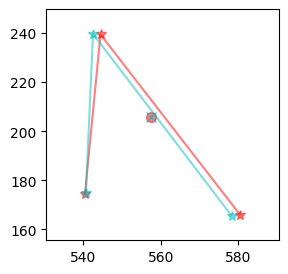

6.283641083295027
0.0 1.729430476210581


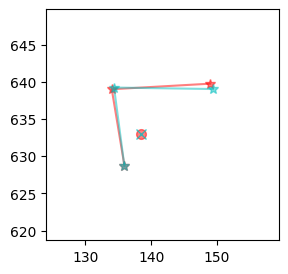

6.693307835086321
0.01 2.3444580515394478


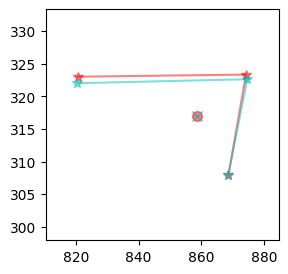

13.725319922594837
0.04 3.800799261369008


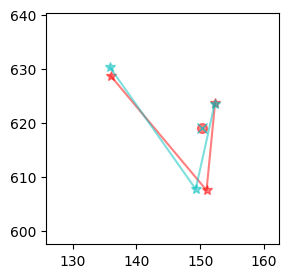

8.195152879004524
0.04 4.101266805270939


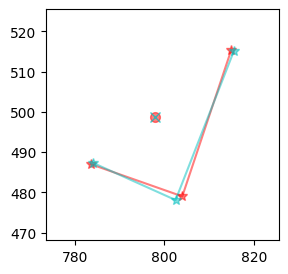

9


In [896]:
# scale = ref_dist / test_dist
# rotation_angle = ref_angle - test_angle

def scale_point(point, ref_point, scale_factor):
    return (
        ref_point[0] + scale_factor * (point[0] - ref_point[0]),
        ref_point[1] + scale_factor * (point[1] - ref_point[1])
    )

def rotate_point(point, ref_point, angle):
    cos_theta = math.cos(angle)
    sin_theta = math.sin(angle)
    # Translate point to origin, apply rotation, then translate back
    translated_x = point[0] - ref_point[0]
    translated_y = point[1] - ref_point[1]
    rotated_x = translated_x * cos_theta - translated_y * sin_theta
    rotated_y = translated_x * sin_theta + translated_y * cos_theta
    return (rotated_x + ref_point[0], rotated_y + ref_point[1])

better_matches = []
for i, match in enumerate(good_matches):
    ref_star = ref_stars[match[0]]
    ref_tri = np.array(ref_tris[match[0]])
    d1 = get_distance(ref_star, ref_tri[0])
    d2 = get_distance(ref_star, ref_tri[1])
    d3 = get_distance(ref_star, ref_tri[2])
    ref_dists = sorted([d1, d2, d3])

    test_star = test_stars[match[1]]
    test_tri = np.array(test_tris[match[1]])
    d4 = get_distance(test_star, test_tri[0])
    d5 = get_distance(test_star, test_tri[1])
    d6 = get_distance(test_star, test_tri[2])
    test_dists = sorted([d4, d5, d6])
    ratio1 = ref_dists[0] / test_dists[0]
    ratio2 = ref_dists[1] / test_dists[1]
    ratio3 = ref_dists[2] / test_dists[2]

    total_diff = round(abs(ratio1 - ratio2) + abs(ratio1 - ratio3) + abs(ratio2 - ratio3), 2)

    if total_diff < 0.1:

        ref_angle = math.atan2(ref_tri[0][1] - ref_star[1], ref_tri[0][0] - ref_star[0])
        test_angle = math.atan2(test_tri[0][1] - test_star[1], test_tri[0][0] - test_star[0])
        rotation_angle = ref_angle - test_angle
        scale_factor = (ratio1 + ratio2 + ratio3) / 3

        scaled_test_star = scale_point(test_star, ref_star, scale_factor)
        rotated_test_star = rotate_point(scaled_test_star, ref_star, rotation_angle)
        translation_vector = (ref_star[0] - rotated_test_star[0], ref_star[1] - rotated_test_star[1])
        aligned_test_star = (rotated_test_star[0] + translation_vector[0], rotated_test_star[1] + translation_vector[1])

        scaled_test_tri = [scale_point(pt, ref_star, scale_factor) for pt in test_tri]
        rotated_test_tri = [rotate_point(pt, ref_star, rotation_angle) for pt in scaled_test_tri]
        aligned_test_tri = np.array([(pt[0] + translation_vector[0],
                                      pt[1] + translation_vector[1]) for pt in rotated_test_tri])

        diff_sums = sum(abs(ref_tri[0] - aligned_test_tri[0]) + abs(ref_tri[1] - aligned_test_tri[1]) + abs(ref_tri[2] - aligned_test_tri[2]))
        if diff_sums < 50:
            print(dists[i])
            print(total_diff, diff_sums)
            better_matches.append([*match, round(scale_factor, 3), round(rotation_angle, 3)])

            fig, ax = plt.subplots(figsize=(3,3))
            ax.plot(ref_star[0], ref_star[1], marker="o", color='r', markersize=7, alpha=0.5)
            ax.plot(ref_tri[:, 0], ref_tri[:, 1], marker="*", color='r', markersize=7, alpha=0.5)
            # ax.plot(test_star[0], test_star[1], marker="o", color='b', markersize=7, alpha=0.5)
            # ax.plot(test_tri[:, 0], test_tri[:, 1], marker="*", color='b', markersize=7, alpha=0.5)
            ax.plot(aligned_test_star[0], aligned_test_star[1], marker="x", color='c', markersize=7, alpha=0.75)
            ax.plot(aligned_test_tri[:, 0], aligned_test_tri[:, 1], marker="*", color='c', markersize=7, alpha=0.5)
            min_x = min(*ref_tri[:, 0], *aligned_test_tri[:, 0])
            max_x = max(*ref_tri[:, 0], *aligned_test_tri[:, 0])
            min_y = min(*ref_tri[:, 1], *aligned_test_tri[:, 1])
            max_y = max(*ref_tri[:, 1], *aligned_test_tri[:, 1])
            ax.set_xlim([min_x - 10, max_x + 10])
            ax.set_ylim([min_y - 10, max_y + 10])
            plt.show()

print(len(better_matches))

In [897]:
better_matches = np.array(better_matches)

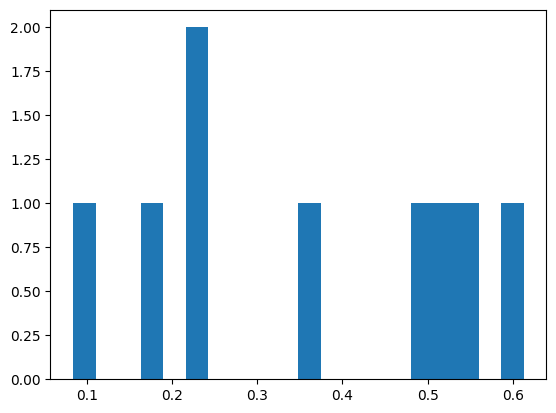

In [956]:
plt.hist(better_matches[:, 2], bins=20)
plt.show()

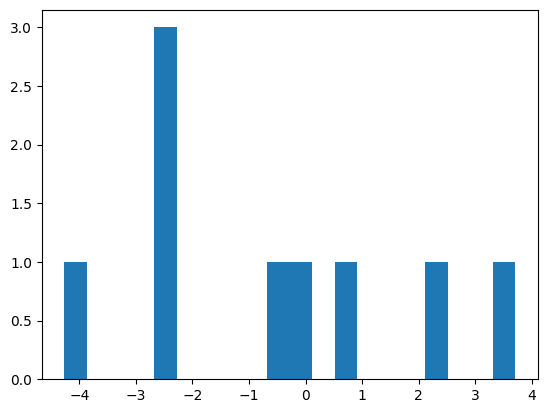

In [957]:
plt.hist(better_matches[:, 3], bins=20)
plt.show()

In [989]:
# scale = ref_dist / test_dist
# rotation_angle = ref_angle - test_angle

def scale_rotate(point, scale_factor, angle):
    cos_theta = math.cos(angle)
    sin_theta = math.sin(angle)
    scaled_x = scale_factor * point[0]
    scaled_y = scale_factor * point[1]
    rotated_x = scaled_x * cos_theta - scaled_y * sin_theta
    rotated_y = scaled_x * sin_theta + scaled_y * cos_theta
    return rotated_x, rotated_y

# messing with these params
final_scale_factor = 0.6
final_roatation_angle = -1.5

proc_test_stars = []
for test_star in test_stars:
    rotated_test_star = scale_rotate(test_star, final_scale_factor, final_roatation_angle)
    proc_test_stars.append(rotated_test_star)

proc_test_tris = []
for test_tri in test_tris:
    rotated_test_tri = [scale_rotate(pt, final_scale_factor, final_roatation_angle) for pt in test_tri]
    proc_test_tris.append(rotated_test_tri)

proc_test_stars = np.array(proc_test_stars)
proc_test_tris = np.array(proc_test_tris)
ref_stars = np.array(ref_stars)

translation_vectors = []
for rid, tid in better_matches[:, :2]:
    rid = int(rid)
    tid = int(tid)
    translation_vector = (ref_stars[rid][0] - proc_test_stars[tid][0], ref_stars[rid][1] - proc_test_stars[tid][1])
    translation_vectors.append(translation_vector)

for rid, tid in better_matches[:, :2]:
    rid = int(rid)
    tid = int(tid)
    translation_vector = (ref_stars[rid][0] - proc_test_tris[tid][0][0], ref_stars[rid][1] - proc_test_tris[tid][0][1])
    translation_vectors.append(translation_vector)

vector_means = np.mean(np.array(translation_vectors), axis=0)
print(vector_means)

aligned_test_stars = []
for star in proc_test_stars:
    aligned_test_star = (star[0] + vector_means[0], star[1] + vector_means[1])
    aligned_test_stars.append(aligned_test_star)

aligned_test_stars = np.array(aligned_test_stars)

proc_test_tris = proc_test_tris.reshape(proc_test_tris.shape[0]*proc_test_tris.shape[1], proc_test_tris.shape[2])
aligned_test_tris = []
for star in proc_test_tris:
    aligned_test_tri = (star[0] + vector_means[0], star[1] + vector_means[1])
    aligned_test_tris.append(aligned_test_tri)

aligned_test_tris = np.array(aligned_test_tris)

[173.65959267 705.1544524 ]


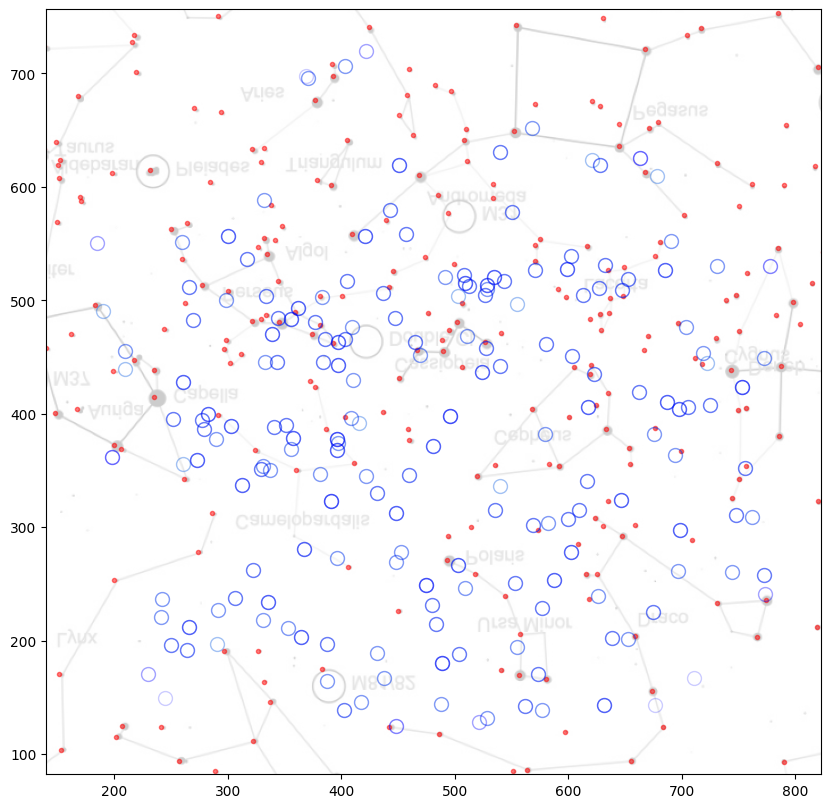

In [990]:
constellations = cv2.imread('data/reference/star_chart_constellations_ireland_2024-10-11_01-00.jpg', flags=cv2.IMREAD_GRAYSCALE)
constellations = cv2.resize(constellations, dsize=(1000,1000))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ref_stars[:,0], ref_stars[:,1], marker="o", color='r', markersize=3, alpha=0.5, linestyle='')
ax.imshow(constellations, cmap="gray", alpha=0.2)
ax.plot(aligned_test_stars[:,0], aligned_test_stars[:,1], marker="o", color='c', markersize=10, linewidth=0.1, alpha=0.2, fillstyle='none', linestyle='')
ax.plot(aligned_test_tris[:, 0], aligned_test_tris[:, 1], marker="o", color='b', markersize=10, linewidth=0.1, alpha=0.2, fillstyle='none', linestyle='')
ax = plt.gca()
ax.set_xlim([aligned_test_stars[:, 0].min() - 50, aligned_test_stars[:, 0].max() + 50])
ax.set_ylim([aligned_test_stars[:, 1].min() - 50, aligned_test_stars[:, 1].max() + 50])
plt.show()


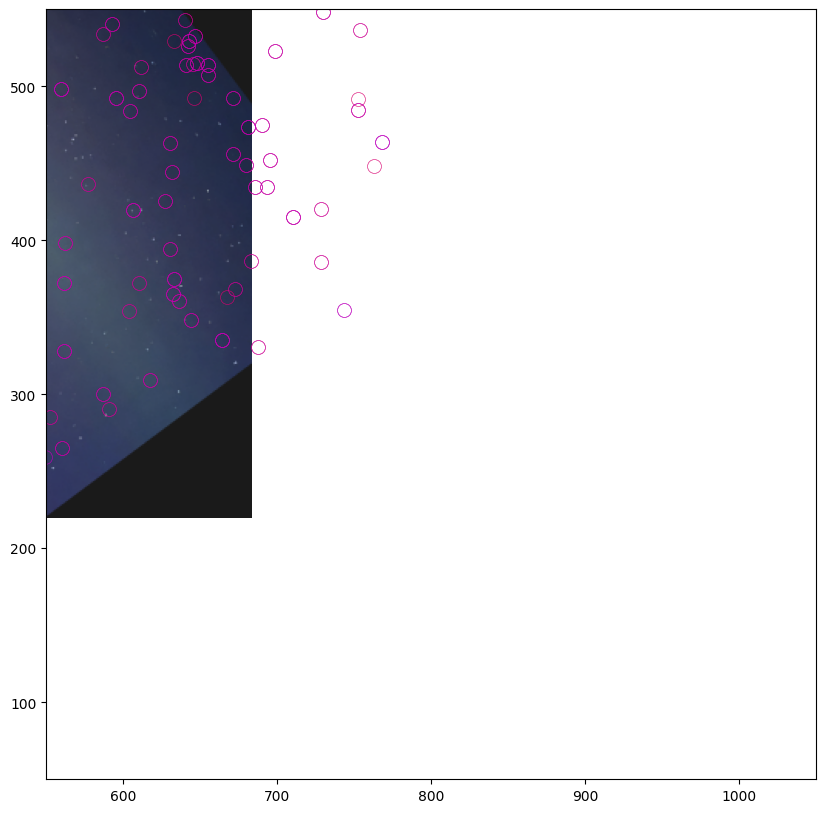

In [ ]:

xmin = aligned_test_stars[:, 0].min()
xmax = aligned_test_stars[:, 0].max()
ymin = aligned_test_stars[:, 1].min()
ymax = aligned_test_stars[:, 1].max()

midpoint = (xmin + xmax) / 2, (ymin + ymax) / 2

scale_factor = 0.4
rotation_angle = 2.5

img = mpimg.imread('data/testing/astro1.jpeg')
scaled_test_img = cv2.resize(img, dsize=(int(1000*scale_factor), int(1000*scale_factor)))
h, w = scaled_test_img.shape[:2]
center = h / 2, w / 2
mat = cv2.getRotationMatrix2D(center, math.degrees(rotation_angle), 1)
roting = cv2.warpAffine(scaled_test_img, mat, (h, w))

fig, ax = plt.subplots(figsize=(10,10))
imgplot = ax.imshow(roting, alpha=0.9)
transform = transforms.Affine2D().translate(xmin - 57.5, ymin - 45)
imgplot.set_transform(transform + ax.transData)
# ax.imshow(constellations, cmap="gray", alpha=0.5)
ax.plot(aligned_test_stars[:,0], aligned_test_stars[:,1], marker="o", markeredgecolor='r', fillstyle='none', markeredgewidth=0.5, markersize=10, alpha=0.5, linestyle='')
ax.plot(aligned_test_tris[:, 0], aligned_test_tris[:, 1], marker="o", markeredgecolor='m', markerfacecolor='none', markeredgewidth=0.5, markersize=10, alpha=0.5, linestyle='')
ax = plt.gca()
ax.set_xlim(550, 1050)
ax.set_ylim(50, 550)
plt.show()
